### CSV cleanup
**input**: credit_card_transactions-ibm_v2.csv

**output**: credit_card_transactions_clean.csv

For now just copied from https://www.kaggle.com/code/jawherjabri/fraud-detection-with-gnn


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
df = pd.read_csv("../data/credit_card_transactions-ibm_v2.csv")

f


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24386900 entries, 0 to 24386899
Data columns (total 15 columns):
 #   Column          Dtype  
---  ------          -----  
 0   User            int64  
 1   Card            int64  
 2   Year            int64  
 3   Month           int64  
 4   Day             int64  
 5   Time            object 
 6   Amount          object 
 7   Use Chip        object 
 8   Merchant Name   int64  
 9   Merchant City   object 
 10  Merchant State  object 
 11  Zip             float64
 12  MCC             int64  
 13  Errors?         object 
 14  Is Fraud?       object 
dtypes: float64(1), int64(7), object(7)
memory usage: 2.7+ GB


In [4]:
df [df['Is Fraud?'] == 'Yes'].shape

(29757, 15)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 [Text(0, 0, 'Errors?'),
  Text(1, 0, 'Zip'),
  Text(2, 0, 'Merchant State'),
  Text(3, 0, 'Month'),
  Text(4, 0, 'User'),
  Text(5, 0, 'Card'),
  Text(6, 0, 'Year'),
  Text(7, 0, 'Amount'),
  Text(8, 0, 'Time'),
  Text(9, 0, 'Day'),
  Text(10, 0, 'Use Chip'),
  Text(11, 0, 'Is Fraud?'),
  Text(12, 0, 'Merchant City'),
  Text(13, 0, 'Merchant Name'),
  Text(14, 0, 'MCC')])

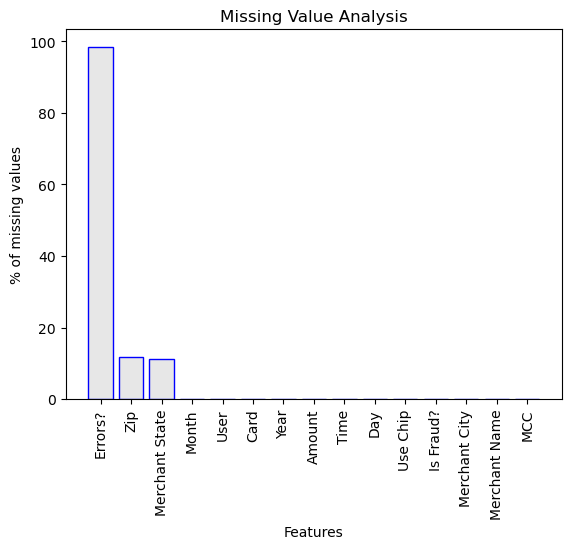

In [5]:
percent_missing=(df.isnull().sum()*100/df.shape[0]).sort_values(ascending=True)
plt.title("Missing Value Analysis")
plt.xlabel("Features")
plt.ylabel("% of missing values")
plt.bar(percent_missing.sort_values(ascending=False).index,percent_missing.sort_values(ascending=False),color=(0.1, 0.1, 0.1, 0.1),edgecolor='blue')
plt.xticks(rotation=90)

In [6]:
df["card_id"] = df["User"].astype(str) + "_" + df["Card"].astype(str)
df["Amount"]=df["Amount"].str.replace("$","").astype(float)
df["Hour"] = df["Time"].str [0:2]
df["Minute"] = df["Time"].str [3:5]

In [7]:
df = df.drop(["Time","User","Card"],axis=1)

In [8]:
df["Errors?"]= df["Errors?"].fillna("No error")

In [9]:
df["Merchant City"]=LabelEncoder().fit_transform(df["Merchant City"])
df["Use Chip"]=LabelEncoder().fit_transform(df["Use Chip"])
df["Errors?"]=LabelEncoder().fit_transform(df["Errors?"])

In [10]:
df.to_csv('../data/credit_card_transactions_clean.csv')